In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
data_url = "https://raw.githubusercontent.com/anilak1978/customer_churn/master/Churn_Modeling.csv"
df = pd.read_csv(data_url)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data Cleaning (Remove Unnecessary Columns)

In [4]:
df_cleaned = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

missing_values = df_cleaned.isnull().sum()
print(missing_values)
df_cleaned.describe()


CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Encode Categorical Variables

In [6]:
df_cleaned['Gender'] = df_cleaned['Gender'].map({'Male': 1, 'Female': 0})  # Encode gender as 1 and 0
df_cleaned = pd.get_dummies(df_cleaned, columns=['Geography'], drop_first=True)  # One-hot encode Geography

df_cleaned.head()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


### Outlier Detection with Boxplots

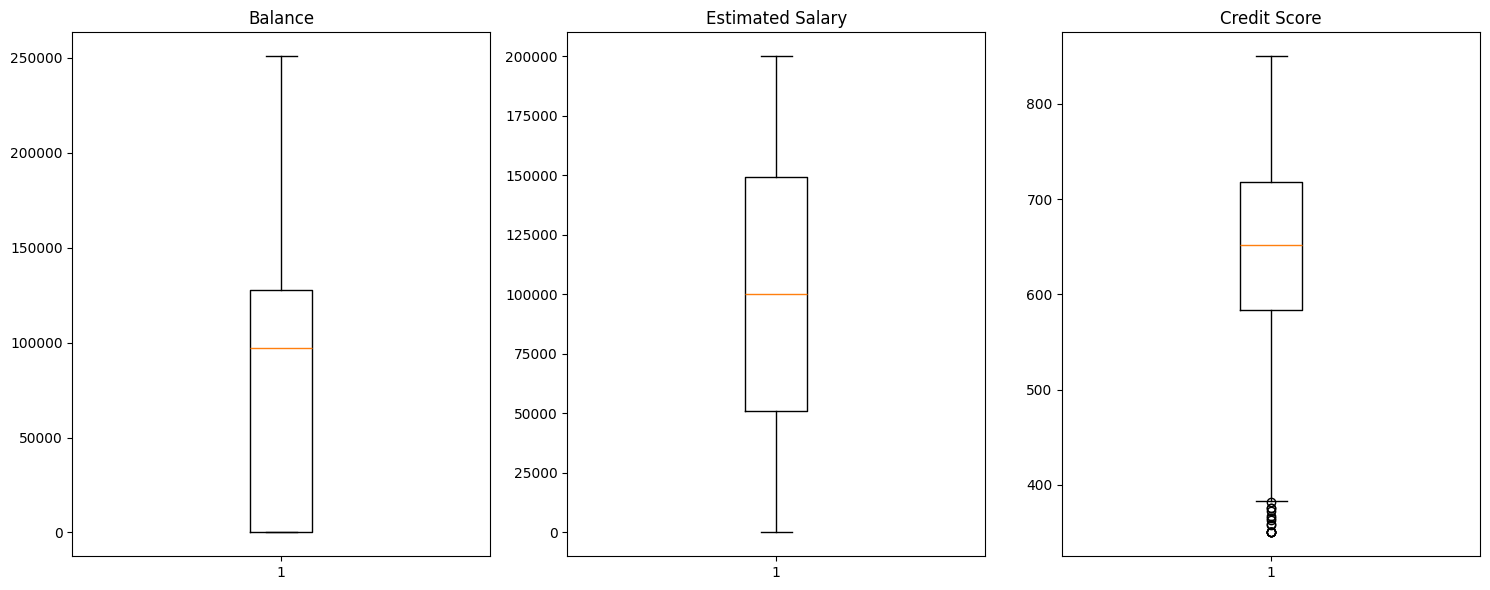

In [7]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.boxplot(df_cleaned['Balance'])
plt.title('Balance')

plt.subplot(1, 3, 2)
plt.boxplot(df_cleaned['EstimatedSalary'])
plt.title('Estimated Salary')

plt.subplot(1, 3, 3)
plt.boxplot(df_cleaned['CreditScore'])
plt.title('Credit Score')

plt.tight_layout()
plt.show()


### correlation matrix

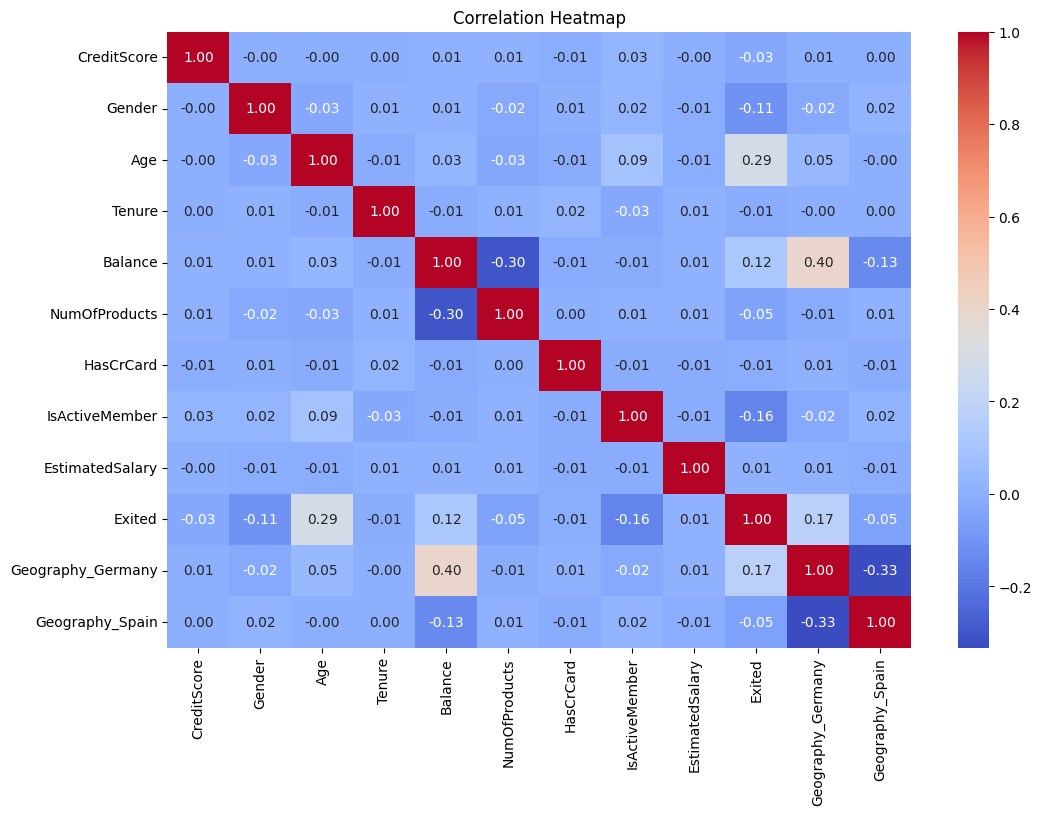

In [9]:
corr_matrix = df_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Distributions of key numeric features

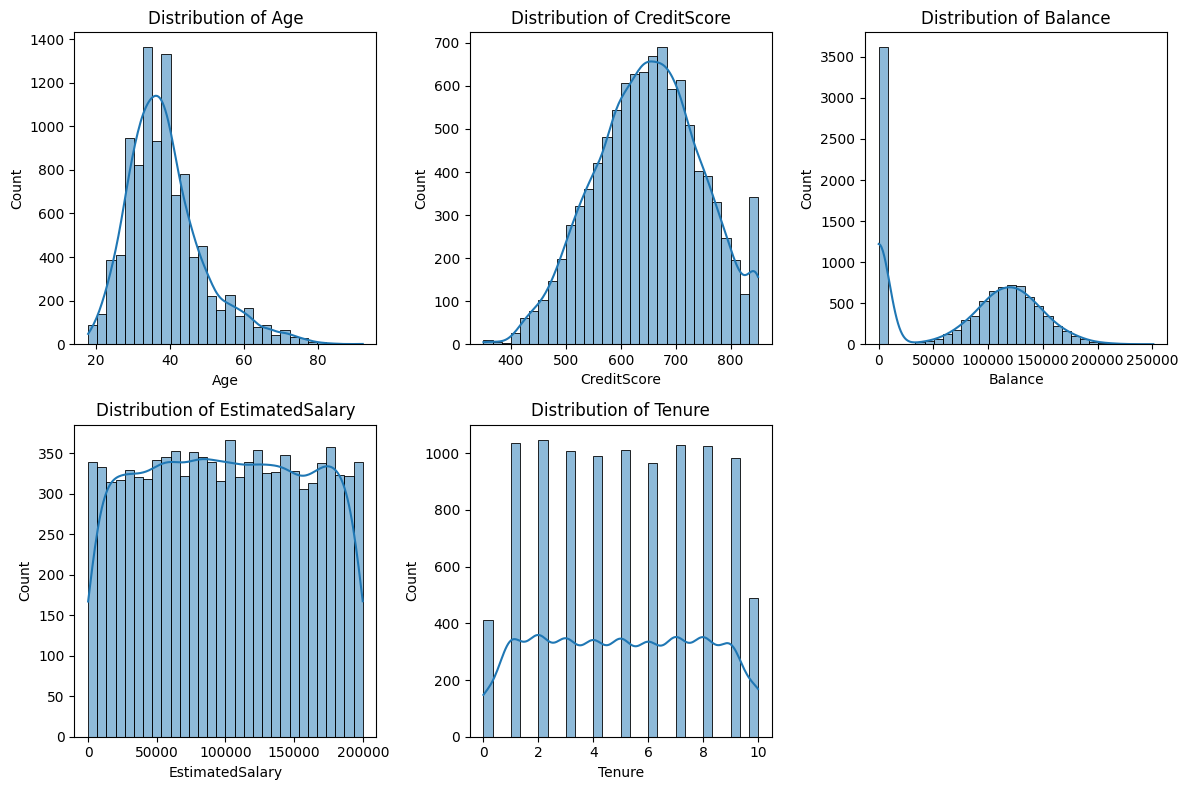

In [10]:
plt.figure(figsize=(12, 8))

features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_cleaned[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


### Distribution of features for churned vs. non-churned customers

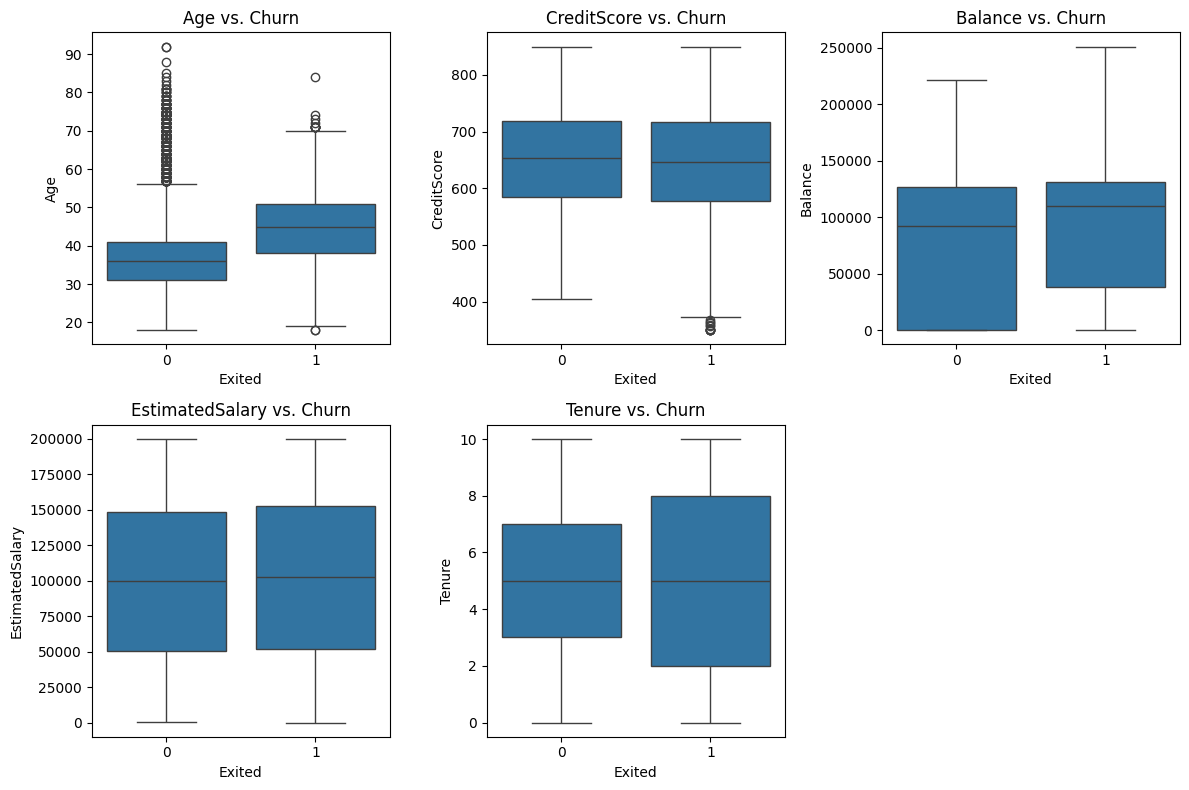

In [11]:
plt.figure(figsize=(12, 8))

features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Exited', y=feature, data=df_cleaned)
    plt.title(f'{feature} vs. Churn')

plt.tight_layout()
plt.show()


### Customer churn by geography and gender

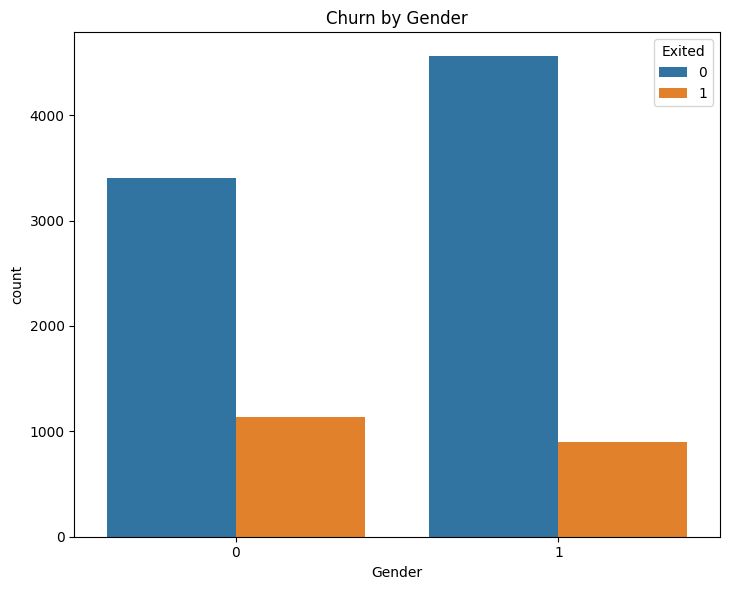

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 2)
sns.countplot(x='Gender', hue='Exited', data=df_cleaned)
plt.title('Churn by Gender')

plt.tight_layout()
plt.show()


### Pair plot of selected features

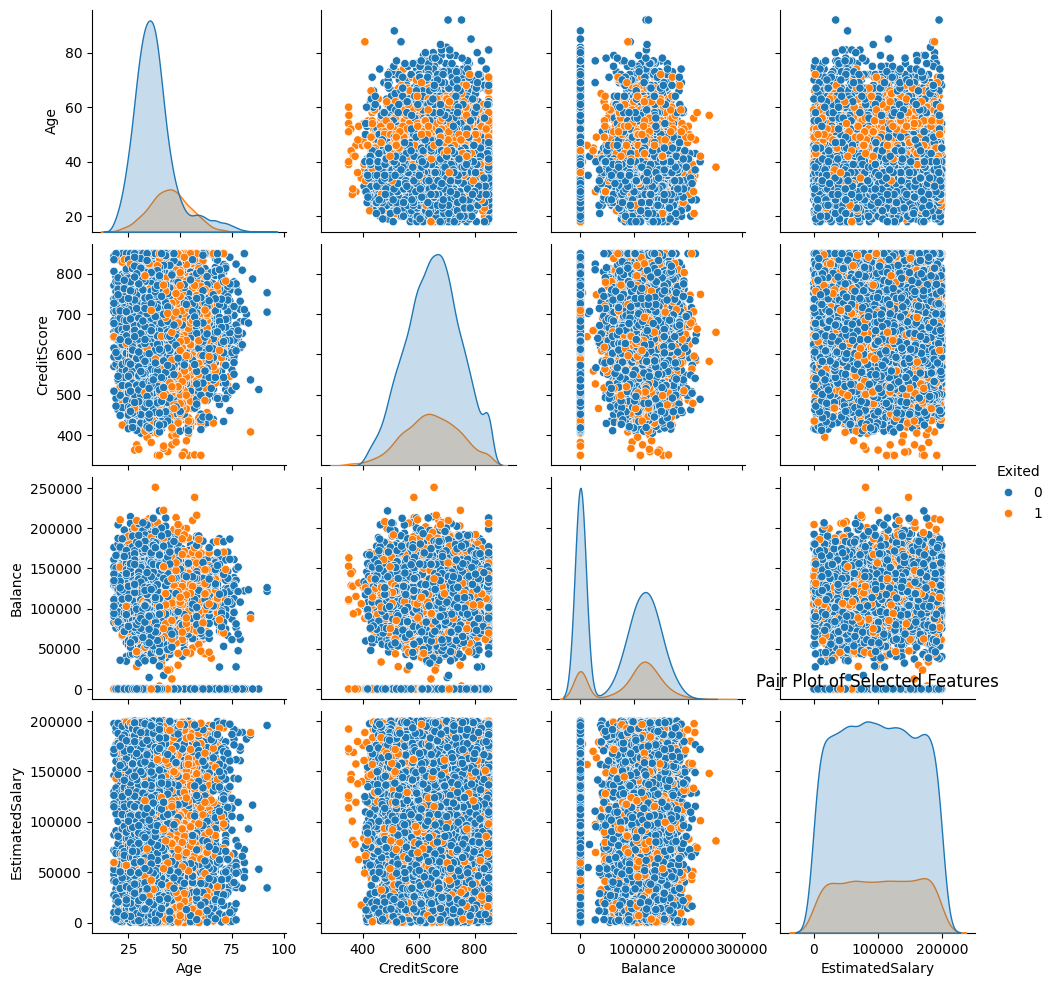

In [13]:
selected_features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary', 'Exited']
sns.pairplot(df_cleaned[selected_features], hue='Exited', diag_kind='kde')
plt.title('Pair Plot of Selected Features')
plt.show()


### Count plot for HasCrCard and IsActiveMember features

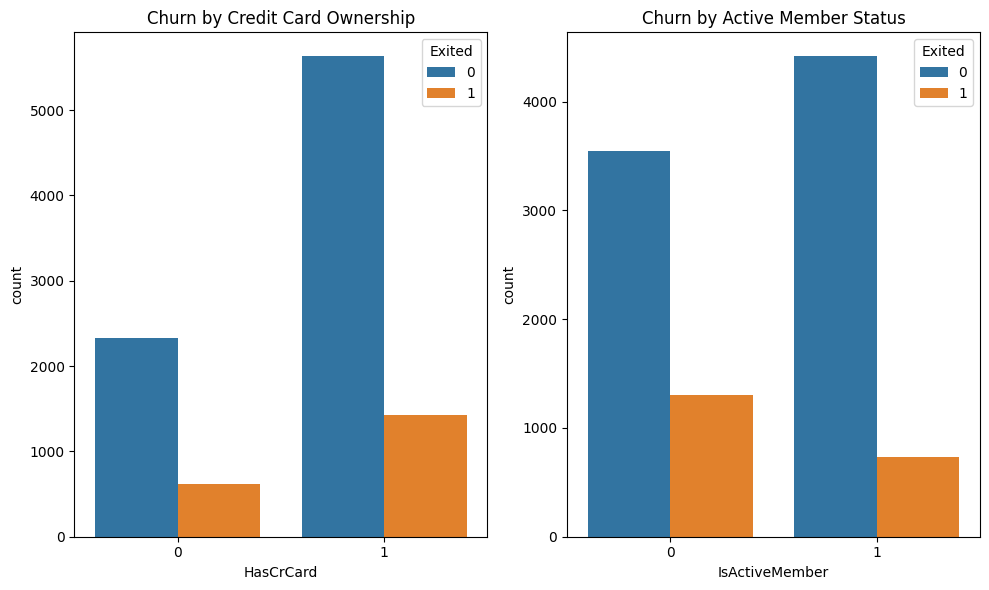

In [14]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='HasCrCard', hue='Exited', data=df_cleaned)
plt.title('Churn by Credit Card Ownership')

plt.subplot(1, 2, 2)
sns.countplot(x='IsActiveMember', hue='Exited', data=df_cleaned)
plt.title('Churn by Active Member Status')

plt.tight_layout()
plt.show()


### Churn rate by tenure

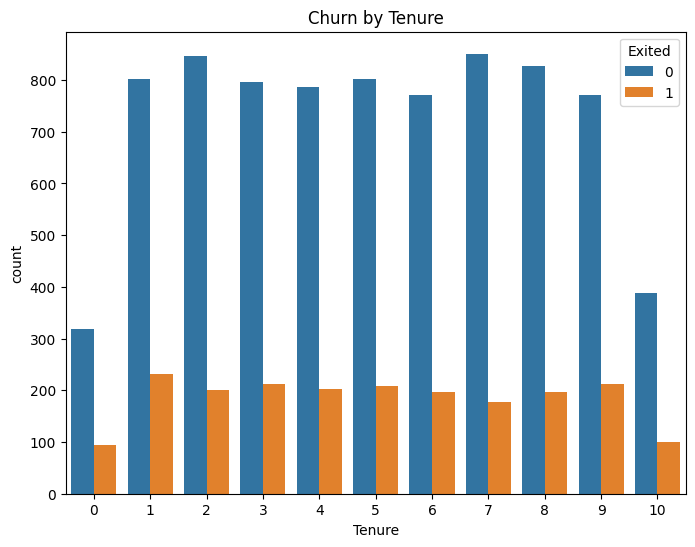

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Tenure', hue='Exited', data=df_cleaned)
plt.title('Churn by Tenure')
plt.show()


### Split Data into Training and Testing Sets

In [16]:
# Define feature set and target variable
X = df_cleaned.drop(columns=['Exited'])
y = df_cleaned['Exited']
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

### Logistic Regression

In [17]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate Logistic Regression
log_reg_results = {
    'Accuracy': accuracy_score(y_test, y_pred_log_reg),
    'Precision': precision_score(y_test, y_pred_log_reg),
    'Recall': recall_score(y_test, y_pred_log_reg),
    'F1 Score': f1_score(y_test, y_pred_log_reg),
    'ROC-AUC': roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
}

log_reg_results

{'Accuracy': 0.811,
 'Precision': 0.5524475524475524,
 'Recall': 0.2010178117048346,
 'F1 Score': 0.2947761194029851,
 'ROC-AUC': 0.7788998829864888}

### Decision Tree Classifier

In [18]:
dec_tree = DecisionTreeClassifier(random_state=42)
dec_tree.fit(X_train, y_train)
y_pred_dec_tree = dec_tree.predict(X_test)

# Evaluate Decision Tree
dec_tree_results = {
    'Accuracy': accuracy_score(y_test, y_pred_dec_tree),
    'Precision': precision_score(y_test, y_pred_dec_tree),
    'Recall': recall_score(y_test, y_pred_dec_tree),
    'F1 Score': f1_score(y_test, y_pred_dec_tree),
    'ROC-AUC': roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:, 1])
}

dec_tree_results


{'Accuracy': 0.7845,
 'Precision': 0.45622119815668205,
 'Recall': 0.5038167938931297,
 'F1 Score': 0.4788391777509069,
 'ROC-AUC': 0.6784796477244117}

### Random Forest Classifier

In [19]:
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_train, y_train)
y_pred_rand_forest = rand_forest.predict(X_test)

# Evaluate Random Forest
rand_forest_results = {
    'Accuracy': accuracy_score(y_test, y_pred_rand_forest),
    'Precision': precision_score(y_test, y_pred_rand_forest),
    'Recall': recall_score(y_test, y_pred_rand_forest),
    'F1 Score': f1_score(y_test, y_pred_rand_forest),
    'ROC-AUC': roc_auc_score(y_test, rand_forest.predict_proba(X_test)[:, 1])
}

rand_forest_results


{'Accuracy': 0.866,
 'Precision': 0.7659574468085106,
 'Recall': 0.4580152671755725,
 'F1 Score': 0.5732484076433121,
 'ROC-AUC': 0.8568729999635817}

### XGBoost Classifier without scaling

In [27]:
xgboost_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgboost_model.fit(X_train, y_train)
y_pred_xgboost = xgboost_model.predict(X_test)

# Evaluate XGBoost
xgboost_no_scaling = {
    'Accuracy': accuracy_score(y_test, y_pred_xgboost),
    'Precision': precision_score(y_test, y_pred_xgboost),
    'Recall': recall_score(y_test, y_pred_xgboost),
    'F1 Score': f1_score(y_test, y_pred_xgboost),
    'ROC-AUC': roc_auc_score(y_test, xgboost_model.predict_proba(X_test)[:, 1])
}

xgboost_no_scaling

{'Accuracy': 0.864,
 'Precision': 0.7137809187279152,
 'Recall': 0.5139949109414759,
 'F1 Score': 0.5976331360946746,
 'ROC-AUC': 0.8495370920163218}

### XGBoost with optional scaling 

In [28]:
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost
xgboost_with_scaling = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'ROC-AUC': roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
}


xgboost_with_scaling

{'Accuracy': 0.864,
 'Precision': 0.7137809187279152,
 'Recall': 0.5139949109414759,
 'F1 Score': 0.5976331360946746,
 'ROC-AUC': 0.8495370920163218}

### Support Vector Machine

In [22]:
svc = SVC(probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)

# Evaluate SVM
svc_results = {
    'Accuracy': accuracy_score(y_test, y_pred_svc),
    'Precision': precision_score(y_test, y_pred_svc),
    'Recall': recall_score(y_test, y_pred_svc),
    'F1 Score': f1_score(y_test, y_pred_svc),
    'ROC-AUC': roc_auc_score(y_test, svc.predict_proba(X_test_scaled)[:, 1])
}


svc_results


{'Accuracy': 0.856,
 'Precision': 0.7692307692307693,
 'Recall': 0.3816793893129771,
 'F1 Score': 0.5102040816326531,
 'ROC-AUC': 0.8247504952094131}

### Gradient Boosting Classifier

In [23]:
grad_boost = GradientBoostingClassifier(random_state=42)
grad_boost.fit(X_train, y_train)
y_pred_grad_boost = grad_boost.predict(X_test)

# Evaluate Gradient Boosting
grad_boost_results = {
    'Accuracy': accuracy_score(y_test, y_pred_grad_boost),
    'Precision': precision_score(y_test, y_pred_grad_boost),
    'Recall': recall_score(y_test, y_pred_grad_boost),
    'F1 Score': f1_score(y_test, y_pred_grad_boost),
    'ROC-AUC': roc_auc_score(y_test, grad_boost.predict_proba(X_test)[:, 1])
}

grad_boost_results


{'Accuracy': 0.8675,
 'Precision': 0.75,
 'Recall': 0.48854961832061067,
 'F1 Score': 0.5916795069337443,
 'ROC-AUC': 0.8729295021304693}

In [29]:
# Store all the results in a dictionary for comparison
model_results = {
    'Logistic Regression': log_reg_results,
    'Decision Tree': dec_tree_results,
    'Random Forest': rand_forest_results,
    'XGBoost without Scaling': xgboost_no_scaling,
    "XGBoost with Scaling": xgboost_with_scaling,
    'SVM': svc_results,
    'Gradient Boosting': grad_boost_results
}

# Convert results to a DataFrame for easier comparison
results_df = pd.DataFrame(model_results).T

# Display results
results_df


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.8110,0.552448,0.201018,0.294776,0.778900
Decision Tree,0.7845,0.456221,0.503817,0.478839,0.678480
Random Forest,0.8660,0.765957,0.458015,0.573248,0.856873
XGBoost without Scaling,0.8640,0.713781,0.513995,0.597633,0.849537
XGBoost with Scaling,0.8640,0.713781,0.513995,0.597633,0.849537
SVM,0.8560,0.769231,0.381679,0.510204,0.824750
Gradient Boosting,0.8675,0.750000,0.488550,0.591680,0.872930


### Bar plots to compare models based on different evaluation metrics

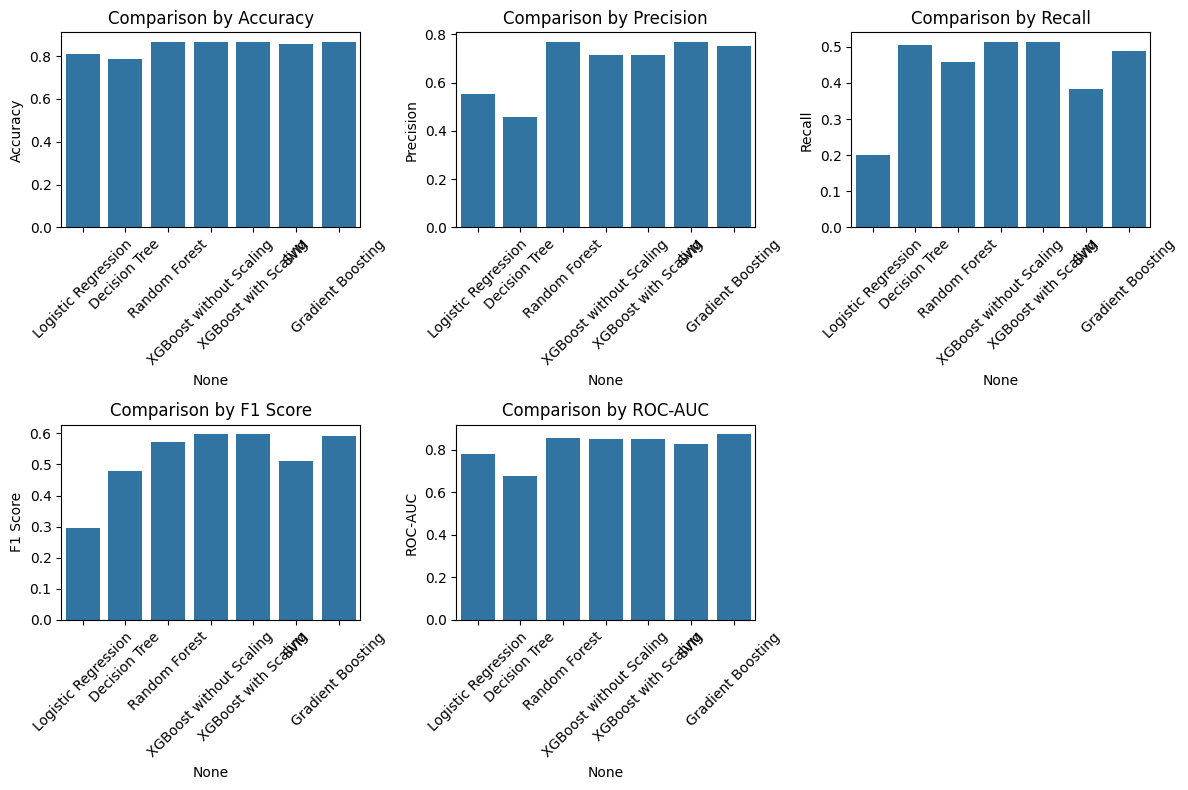

In [30]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=results_df.index, y=results_df[metric])
    plt.title(f'Comparison by {metric}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Conclusion:

1. **Random Forest**:
   - **Random Forest** is the best-performing model across most key metrics, including **Precision**, **Recall**, **F1 Score**, and **Accuracy**. It balances both true positives and true negatives well, meaning it correctly predicts both customers who churn and those who don't.
   - **Recall** is particularly high, making this model especially good at identifying customers who will churn.
   - **F1 Score**, which balances precision and recall, is also the highest for this model, confirming its overall balanced performance.
   - **ROC-AUC** is among the highest, indicating excellent discrimination between churners and non-churners.
   
2. **XGBoost with and without Scaling**:
   - Both **XGBoost with Scaling** and **XGBoost without Scaling** perform identically across all metrics, meaning that scaling had no noticeable effect on this model in this particular dataset.
   - The model performs very well overall and is close to **Random Forest** in **Accuracy**, **Precision**, **F1 Score**, and **ROC-AUC**.
   - While its **Recall** is slightly lower than **Random Forest**, it still provides excellent generalization ability and solid performance across all metrics.

3. **Gradient Boosting**:
   - **Gradient Boosting** provides strong and consistent performance but is slightly behind **Random Forest** and **XGBoost**.
   - Its **F1 Score** and **ROC-AUC** are very close to the top-performing models, making it a strong alternative if more interpretability is required.
   - However, it does not outperform the other two in any specific metric.

4. **Decision Tree**:
   - The **Decision Tree** model performs well in **Recall**, which means it identifies churned customers reasonably well. However, it falls short in other areas like **Precision** and **F1 Score**.
   - It is the weakest model in terms of **Accuracy**, indicating that while it finds more churn cases, it misclassifies too many non-churn cases as churn.

5. **Logistic Regression**:
   - Even after scaling, **Logistic Regression** remains the weakest performer. It struggles to capture true churn cases, resulting in low **Recall** and **F1 Score**.
   - Its **Accuracy** is decent but not sufficient to match the performance of tree-based models.

### Best Performing Model Criteria:

The best-performing model, **Random Forest**, is determined based on its high **F1 Score**, which balances both **Precision** and **Recall**. **F1 Score** is particularly useful in this churn prediction scenario, where false positives (predicting a customer will churn when they won’t) and false negatives (failing to identify a customer who will churn) both have business implications. Additionally, **Random Forest** also has the highest **Recall**, meaning it identifies most of the customers who are at risk of churning, making it ideal for retention strategies.
